# Specification

## Project 1 -Predict secondary protein structure given the sequence. 

### Completion requirements:

- Reimplement the network described by Qian and Sejnowski in 1988


- Test and compare your accuracy - using their data


- Implement a single improvement, such as profiling


- Test and compare your accuracy again


- Does the model get similar accuracy on unseen datasets?


- Extend your work to other methods, e.g. can large language models help? How about SVMs?

# Import Modules

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping


2024-05-14 02:30:26.873020: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 02:30:26.878905: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 02:30:26.970189: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 02:30:28.403815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Import Dataset

In [2]:
# Define a function to convert amino acids and structures to one-hot

def one_hot_encode(seq, vocab):
    """One-hot encode a sequence based on a given vocabulary."""
    one_hot = np.zeros((len(seq), len(vocab)), dtype=np.float32)
    for i, char in enumerate(seq):
        if char in vocab:
            one_hot[i, vocab.index(char)] = 1.0
    return one_hot

def prepare_data(filepath, window_size=13):
    sequences = []
    structures = []
    current_seq = []
    current_struct = []
    processing_sequence = False  # Track when inside a sequence block

    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if line == '<>':  # Toggle processing flag
                if processing_sequence:  # We are ending a sequence block
                    if current_seq and current_struct:
                        seq_encoded = one_hot_encode(current_seq, aa_vocab)
                        struct_encoded = one_hot_encode(current_struct, structure_vocab)

                        # Apply sliding window
                        for i in range(len(seq_encoded) - window_size + 1):
                            window = seq_encoded[i:i + window_size]
                            label = struct_encoded[i + window_size // 2]
                            sequences.append(window)
                            structures.append(label)

                    current_seq = []
                    current_struct = []
                processing_sequence = not processing_sequence
                continue

            elif 'end' in line:  # Generalized handling for any 'end' marker
                continue  # Just skip this line, do not end processing sequence

            if processing_sequence:
                parts = line.split()
                if len(parts) != 2:
                    continue  # Skip malformed lines or lines that do not fit expected format
                current_seq.append(parts[0])
                current_struct.append(parts[1])

    return np.array(sequences), np.array(structures)


# Define your vocabularies
aa_vocab = 'ACDEFGHIKLMNPQRSTVWY_'  # 20 amino acids + 1 for gap/unknown
structure_vocab = 'he_'  # h for helix, e for sheet, _ for coil

# Example paths, replace with your actual file pathsin
train_path = 'Q_and_s_data/protein-secondary-structure.train.txt'
test_path = 'Q_and_s_data/protein-secondary-structure.test.txt'

x_train, y_train = prepare_data(train_path)
x_test, y_test = prepare_data(test_path)

In [3]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(8110, 13, 21) (8110, 3)
(1714, 13, 21) (1714, 3)


# Performane Metrics

In [8]:
from sklearn.metrics import confusion_matrix

def calculate_q3_score(y_true, y_pred):
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return np.mean(y_true_classes == y_pred_classes)

def calculate_correlation_coefficients(y_true, y_pred):
    """Calculates Pearson correlation coefficients for each class."""
    correlations = []
    for i in range(y_true.shape[1]):  # Assuming y_true is one-hot encoded
        # Extract the actual and predicted values for each class
        true_values = y_true[:, i]
        pred_values = y_pred[:, i]
        
        # Calculate correlation using numpy's corrcoef, which returns a correlation matrix
        if np.std(true_values) != 0 and np.std(pred_values) != 0:
            corr_matrix = np.corrcoef(true_values, pred_values)
            corr_coefficient = corr_matrix[0, 1]  # Extract the off-diagonal value which is the correlation coefficient
            correlations.append(corr_coefficient)
        else:
            correlations.append(0)  # Avoid division by zero in case of constant true or pred values
    return correlations

def matthews_correlation_coefficient(y_true, y_pred):
    """Calculate the Matthews correlation coefficient for each class."""
    MCCs = []
    # Assuming y_true and y_pred are one-hot encoded, decode to single class predictions
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Get unique classes
    classes = np.unique(y_true_classes)
    
    for class_id in classes:
        # Create binary arrays for each class
        true_binary = (y_true_classes == class_id).astype(int)
        pred_binary = (y_pred_classes == class_id).astype(int)
        
        # Compute the confusion matrix
        tn, fp, fn, tp = confusion_matrix(true_binary, pred_binary).ravel()
        
        # Compute MCC
        mcc_numerator = (tp * tn) - (fp * fn)
        mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        mcc = mcc_numerator / mcc_denominator if mcc_denominator != 0 else 0
        MCCs.append(mcc)
    
    return MCCs


# Model Architecture 

Single Network 

In [3]:
tf.keras.utils.set_random_seed(42)


# Define the model architecture
model = Sequential([
    Flatten(input_shape=(13, 21)),  # Assuming input is a window of 13 amino acids, each encoded into 21 types
    Dense(40, activation='sigmoid'),  # First hidden layer with sigmoid activation, 40 units
    Dense(3, activation='linear')    # Output layer with sigmoid activation for 3 classes
])

# Compile the model
model.compile(optimizer='sgd',  # Stochastic gradient descent
              loss='mean_squared_error',  # Mean Squared Error as the loss function
              metrics=['accuracy'])  # Track accuracy


early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=100,  # The number of epochs can be adjusted based on when you observe convergence
    batch_size=32,  # The batch size can be tuned based on your hardware capabilities
    validation_data=(x_test, y_test),  # Use your test set for validation
    callbacks=[early_stopping]

)

final_pred = model.predict(x_test)


/home/tom/miniconda3/envs/bio-wsl/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


2024-05-14 02:30:49.162633: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8856120 exceeds 10% of free system memory.


254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4548 - loss: 0.2350 - val_accuracy: 0.5560 - val_loss: 0.2023
Epoch 2/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5251 - loss: 0.2087 - val_accuracy: 0.5554 - val_loss: 0.2008
Epoch 3/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5264 - loss: 0.2067 - val_accuracy: 0.5572 - val_loss: 0.1995
Epoch 4/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5293 - loss: 0.2049 - val_accuracy: 0.5572 - val_loss: 0.1982
Epoch 5/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5324 - loss: 0.2032 - val_accuracy: 0.5589 - val_loss: 0.1970
Epoch 6/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5334 - loss: 0.2016 - val_accuracy: 0.5624 - val_loss: 0.1959
Epoch 7/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5362 - loss: 0.2001 - val_accuracy: 0.5642 - val_loss: 0.1948
Epoch 8/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5370 - loss: 0.1986 - val_accuracy: 0.5659

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef

# Convert probabilities to class labels
y_true_labels = np.argmax(y_test, axis=1)
predicted_labels = np.argmax(final_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_labels, predicted_labels)
print("Q3 Score:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Calculate Matthews Correlation Coefficient for each class
# Calculate MCC for each class
mcc_scores = []
for i in range(3):  # 3 classes: Helix, Sheet, Coil
    # Create binary arrays for each class
    true_binary = (y_true_labels == i).astype(int)
    pred_binary = (predicted_labels == i).astype(int)

    # Calculate MCC and handle cases with constant predictions
    if np.unique(true_binary).size > 1 and np.unique(pred_binary).size > 1:
        mcc = matthews_corrcoef(true_binary, pred_binary)
    else:
        mcc = 0  # Not enough data to compute MCC or one class constant
    mcc_scores.append(mcc)
    print(f"MCC for class {['Helix', 'Sheet', 'Coil'][i]}: {mcc:.3f}")

Q3 Score: 0.6330221703617269
Confusion Matrix:
 [[179  16 240]
 [ 70  77 179]
 [ 91  33 829]]
MCC for class Helix: 0.312
MCC for class Sheet: 0.302
MCC for class Coil: 0.357


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


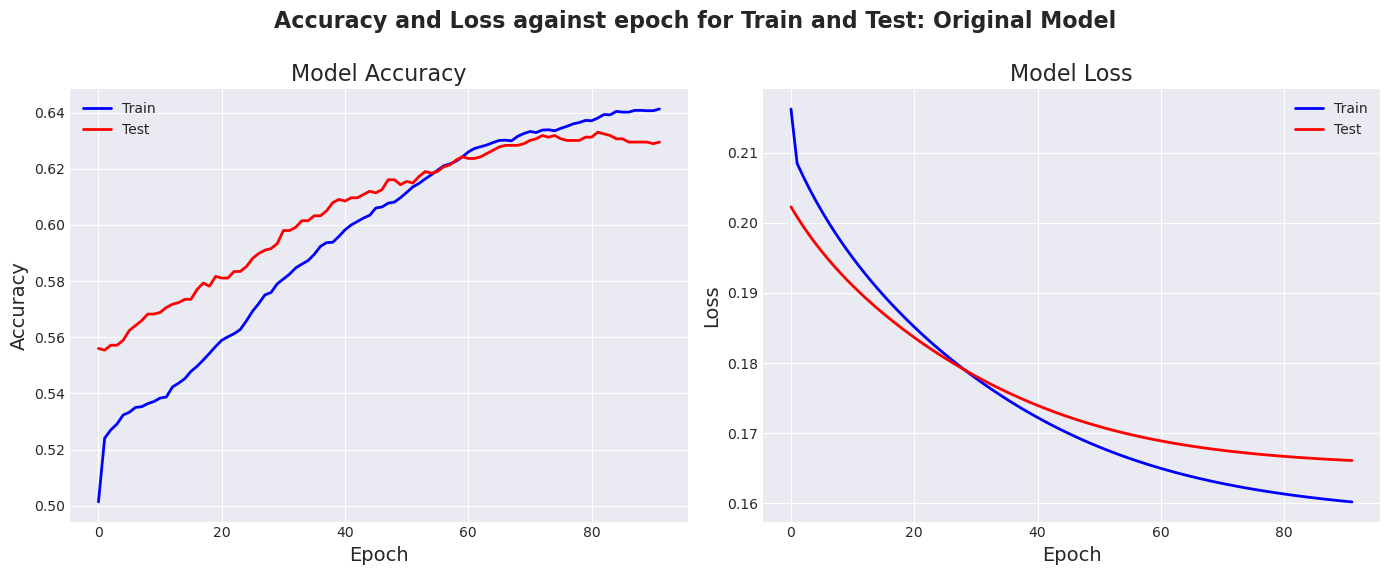

In [5]:
import matplotlib.pyplot as plt
print(plt.style.available)


def plot_history(history):
 # Set the style
    plt.style.use('seaborn-v0_8-dark')  # Using a clean and professional style

    # Create figure and set size
    plt.figure(figsize=(14, 6))
    plt.suptitle('Accuracy and Loss against epoch for Train and Test: Original Model', fontsize=16, fontweight='bold', y=0.95)

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], linestyle='-', color='blue', linewidth=2)
    plt.plot(history.history['val_accuracy'], linestyle='-', color='red', linewidth=2)
    plt.title('Model Accuracy', fontsize=16)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.grid(True)

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], linestyle='-', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], linestyle='-', color='red', linewidth=2)
    plt.title('Model Loss', fontsize=16)
    plt.ylabel('Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.grid(True)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the bottom rect to reduce the space
    
    # save the plot
    #plt.savefig('figures/original_model_accuracy_loss.png',dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

plot_history(history)  # Plot for the first model
#plot_history(history_second) 